In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Rectangle


In [2]:
# Caminhos
image_dir = 'face_mask_dataset/images'
annot_dir = 'face_mask_dataset/annotations'

# Tamanho das imagens
IMG_SIZE = 100

# Classes
CLASSES = ['with_mask', 'without_mask']

X = []
y = []

# Loop sobre os arquivos de anotação
for filename in os.listdir(annot_dir):
    if not filename.endswith('.xml'):
        continue

    annot_path = os.path.join(annot_dir, filename)
    tree = ET.parse(annot_path)
    root = tree.getroot()

    image_filename = root.find('filename').text
    image_path = os.path.join(image_dir, image_filename)

    image = cv2.imread(image_path)
    if image is None:
        continue

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in CLASSES:
            continue

        bbox = obj.find('bndbox')
        x1 = int(float(bbox.find('xmin').text))
        y1 = int(float(bbox.find('ymin').text))
        x2 = int(float(bbox.find('xmax').text))
        y2 = int(float(bbox.find('ymax').text))

        face = image[y1:y2, x1:x2]
        try:
            face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
            face = face / 255.0
            X.append(face)
            y.append(CLASSES.index(label))
        except:
            continue

X = np.array(X)
y = to_categorical(y)

print("Total de imagens:", len(X))
print("Formato das imagens:", X.shape)


Total de imagens: 3949
Formato das imagens: (3949, 100, 100, 3)


In [3]:
#Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,186,370 (8.34 MB)

 Trainable params: 2,186,370 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#6. Treinar o modelo

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.8650 - loss: 0.3544 - val_accuracy: 0.9722 - val_loss: 0.1001
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9494 - loss: 0.1299 - val_accuracy: 0.9772 - val_loss: 0.0921
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.9556 - loss: 0.1316 - val_accuracy: 0.9696 - val_loss: 0.0882
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.9597 - loss: 0.1190 - val_accuracy: 0.9747 - val_loss: 0.0738
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9683 - loss: 0.1055 - val_accuracy: 0.9747 - val_loss: 0.0706
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.9711 - loss: 0.0962 - val_accuracy: 0.9759 - val_loss: 0.0772
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9684 - loss: 0.0949 - val_accuracy: 0.9759 - val_loss: 0.0986
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.9679 - loss: 0.0835 - val_accu

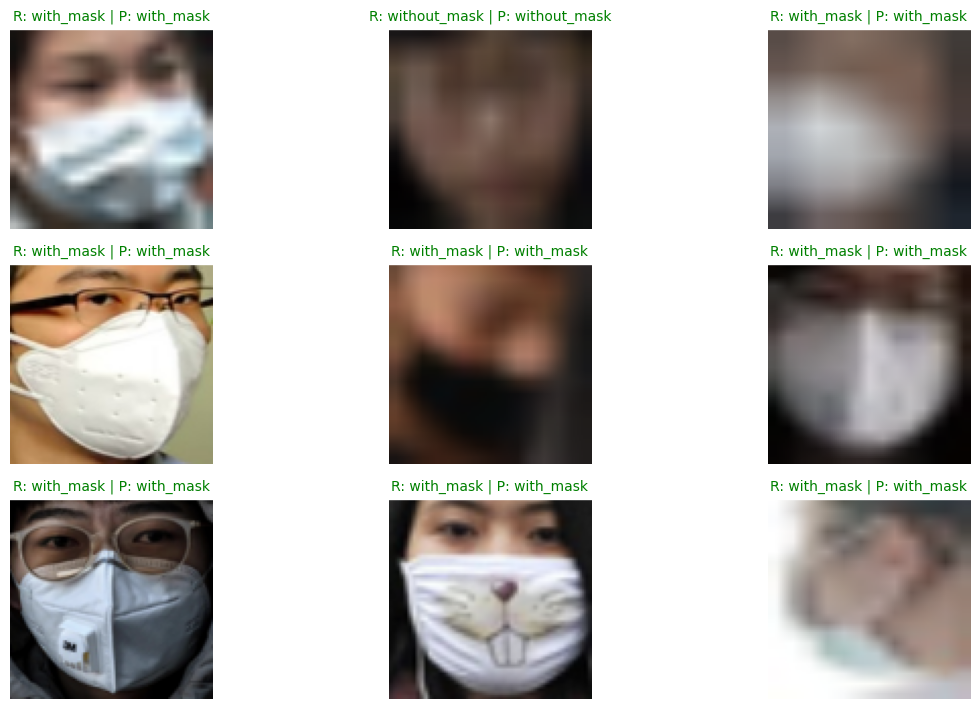

In [8]:
# Número de amostras e layout da grade
num_amostras = 9
linhas, colunas = 3, 3

indices = random.sample(range(len(X_test)), num_amostras)

plt.figure(figsize=(12.8, 7.2), dpi=100)  

for i, idx in enumerate(indices):
    image = X_test[idx]
    true_label = np.argmax(y_test[idx])
    pred_label = np.argmax(model.predict(np.expand_dims(image, axis=0), verbose=0))

    # Corrige BGR para RGB
    image_rgb = (image * 255).astype(np.uint8)
    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

    # Mostra imagem em subplot
    plt.subplot(linhas, colunas, i + 1)
    plt.imshow(image_rgb)
    cor = 'green' if true_label == pred_label else 'red'
    titulo = f"R: {CLASSES[true_label]} | P: {CLASSES[pred_label]}"
    plt.title(titulo, fontsize=10, color=cor, backgroundcolor='white', pad=5)
    plt.axis('off')

plt.tight_layout()
plt.show()